In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#data processing and adding a validation set

In [3]:
os.chdir('C:/Users/hanso/OneDrive/Desktop/Projects/forestFireDetector/forestFireData/Data')
if os.path.isdir('Valid_Data/Non_Fire') is False:
    os.makedirs('Valid_Data/Non_Fire')
    os.makedirs('Valid_Data/Fire')
    os.chdir("C:/Users/hanso/OneDrive/Desktop/Projects/forestFireDetector/forestFireData/Data/Train_Data/Non_Fire")
    #moving part of train data into valid set
    for i in random.sample(glob.glob('NF_*'), 90): #10% of train set
        shutil.move(i, 'C:/Users/hanso/OneDrive/Desktop/Projects/forestFireDetector/forestFireData/Data/Valid_Data/Non_Fire')
    os.chdir("C:/Users/hanso/OneDrive/Desktop/Projects/forestFireDetector/forestFireData/Data/Train_Data/Fire")
    for i in random.sample(glob.glob('F_*.jpg'), 90):
        shutil.move(i, 'C:/Users/hanso/OneDrive/Desktop/Projects/forestFireDetector/forestFireData/Data/Valid_Data/Fire')   
os.chdir('C:/Users/hanso/OneDrive/Desktop/Projects/forestFireDetector')


In [4]:
train_path='C:/Users/hanso/OneDrive/Desktop/Projects/forestFireDetector/forestFireData/Data/Train_Data'
valid_path='C:/Users/hanso/OneDrive/Desktop/Projects/forestFireDetector/forestFireData/Data/Valid_Data'
test_path='C:/Users/hanso/OneDrive/Desktop/Projects/forestFireDetector/forestFireData/Data/Test_Data'

In [5]:
#image processing using vgg16 preprocess
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(224,224), classes=['Fire', 'Non_Fire'], batch_size=10) #flow_from_dir(directory path, resize factor for all imgs, list of class subdirectory, batch size) 
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224,224), classes=['Fire', 'Non_Fire'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size=(224,224), classes=['Fire', 'Non_Fire'], batch_size=10)

Found 1220 images belonging to 2 classes.
Found 180 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [6]:
#populating labels
imgs, labels = next(train_batches)

In [7]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1,10,figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

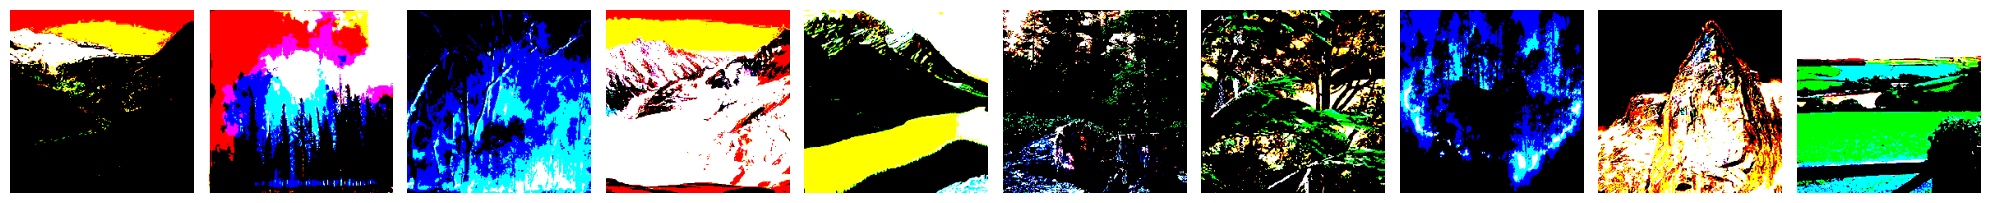

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [8]:
#previewing processed images, labels
plotImages(imgs)
print(labels)

In [9]:
#building the VGG16 model

In [10]:
model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224,224, 3)),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(256, activation='relu',name='fc1'),
    Dense(128, activation='relu',name='fc2'),
    Dense(1, activation='sigmoid',name='output') #using sigmoid and 1 node since model is binary classification
    
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                   

In [12]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy']) #use binary cross for binary classification

In [14]:
gpuAvail = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs available: ", len(gpuAvail))

Num GPUs available:  0


In [13]:
model.fit(x=train_batches, validation_data = valid_batches, epochs=10, verbose=2)
#note original dataset has some corrupted images might need to sift thorugh them if using the whole set

Epoch 1/10




KeyboardInterrupt: 